### 무한 루프 방지 및 비용 최적화
1. 문제 상황: 노드 간 순환 구조에서 무한 루프 발생 가능성 및 부적절한 결과 반복 시 리소스(토큰) 낭비 위험.
2. 해결 전략: State에 count 필드 추가 + 선행 제어(Pre-control) 방식 채택
- 기존 방식: 작업 노드 실행 후 라우터에서 count 체크 (이미 실행된 노드의 비용 발생).
- 개선 방식: 작업 노드 진입 전, 이전 단계의 판단 라우터에서 count를 선제적으로 확인.

3. 검증 로직 요약
- route_after_doc_relevance 라우트 함수에서 doc_relevance_status와 rewrite_count 모두 고려하려 라우팅 
- Relevant: generate 
- Irrelevant: 
    * count < limit: rewrite
    * count >= limit: 즉시 종료 노드(inform_failure)로 분기하여 불필요한 실행 차단.
-  "irrelevant" + "count >= limit" => 최대 횟수로 재시도 했음에도 실패하였다는 의미 

4. 기대 효과
- 비용 최적화: 한계치 도달 시 불필요한 LLM 호출을 원천 봉쇄.
- 책임 분리: 작업 노드는 기능에만 집중하고, 라우터가 흐름 제어(Flow Control)를 전담하여 구조적 명확성 확보.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

# 기존에 생성한 vector store 불러오기 
vector_store = Chroma(
    embedding_function=embeddings,
    collection_name = 'income_tax_collection',
    persist_directory = '../income_tax_collection' #로컬에 영구 저장 버전 
)

In [3]:
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [4]:
# State 정의 
from typing import Literal
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

DOC_RELEVANCE_LITERAL = Literal["relevant", "irrelevant"]
HALLUCINATION_LITERAL = Literal["grounded", "hallucinated"]
HELPFULNESS_LITERAL = Literal["helpful", "unhelpful"] 

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

    # 검증 결과 
    doc_relevance_status: DOC_RELEVANCE_LITERAL
    hallucination_status: HALLUCINATION_LITERAL
    helpfulness_status: HELPFULNESS_LITERAL

    # 검증 시도 횟수 
    rewrite_count: int      # 질문 재작성 시도 횟수 
    generation_count: int   # LLM 답변 생성 시도 횟수 

In [5]:
# Node 정의
# 사용자 query로 vector store에서 검색을 수행하는 노드 
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    
    docs = retriever.invoke(query)

    return {'context': docs}

In [6]:
from langchain_openai import ChatOpenAI
from langsmith import Client

llm = ChatOpenAI(model='gpt-4o')
client = Client()

In [7]:
# context와 query를 받아서 LLM 답변을 생성하는 노드 
def generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    
    prompt = client.pull_prompt("rlm/rag-prompt")
    rag_chain = prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response.content, 'generation_count': state['generation_count']+1}

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 검색 결과의 정확도를 높이도록 사용자 쿼리를 변환하는 노드 
def rewrite(state: AgentState) -> AgentState:
    query = state['query']
    dictionary = ["사람을 나타내는 표현 -> 거주자"]

    keyword_dictionary_prompt = PromptTemplate.from_template(
        f"""사용자의 질문을 보고, 키워드 사전을 참고해서 사용자의 질문을 변경해주세요. 
        사전: {dictionary}
        사용자의 질문: {{question}}
        """
    )
    keyword_dictionary_chain = keyword_dictionary_prompt| llm | StrOutputParser()
    rewritten_query = keyword_dictionary_chain.invoke({'question': query})

    return {'query': rewritten_query, 'rewrite_count': state['rewrite_count']+1}

In [9]:
validation_llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [10]:
# retriver에서 검색한 문서의 관련성을 판단하는 노드 
def check_doc_relevance(state: AgentState):
    query = state['query'] 
    context = state['context'] 

    doc_relevance_prompt = client.pull_prompt("rlm/rag-document-relevance")

    doc_relevance_chain = doc_relevance_prompt | validation_llm

    response = doc_relevance_chain.invoke({
        "input": {
            "question": query,
            "documents": context
        }
    })
    
    # doc_relevance_chain의 결과: 문서 관련성이 높으면 1, 아니면 0 
    if response['Score'] == 1:
        return {"doc_relevance_status": "relevant"}
    else:
        return {"doc_relevance_status": "irrelevant"}

def route_after_doc_relevance(state: AgentState):
    result = state["doc_relevance_status"]
    if(result == "relevant"):
        return "generate"
    else:
        if(state['rewrite_count'] >= 2): # 2번 재작성했는데도 "irrelevant"면 답변 작성 실패
            return "inform_failure"
        else:
            return "rewrite"

In [11]:
# 할루시네이션 검증 노드  
def check_hallucination(state: AgentState):
    context = state["context"]
    answer = state["answer"]

    hallucination_prompt = PromptTemplate.from_template("""
        You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
        Given documents, which are excepts from income tax law, and a student's answer;
        If the student's answer is based on documents, respond with "grounded",
        If the student's answer is not based on documents, respond with "hallucinated".

        documents: {documents}
        student_answer: {student_answer}
        """
    )

    hallucinations_chain = hallucination_prompt | validation_llm | StrOutputParser()
    
    # 평가 실행
    response = hallucinations_chain.invoke({
        "documents": context,
        "student_answer": answer 
    })

    # 판단 결과를 State에 업데이트합니다.
    return {"hallucination_status": response}

def route_after_hallucination(state: AgentState):
    result = state["hallucination_status"]
    if(result == "grounded"):
        return "check_helpfulness"
    else:
        if(state['generation_count'] >= 4): # 4번 생성했는데도 "hallucinated"면 답변 작성 실패
            return "inform_failure"
        else:
            return "generate"

In [12]:
# 유용성 검증 노드 
from langgraph.graph import END

def check_helpfulness(state:AgentState):
    query = state['query']
    answer = state['answer']

    # Hub에서 검증된 프롬프트 가져오기
    helpfulness_prompt = client.pull_prompt("rlm/rag-answer-helpfulness")

    helpfulness_chain = helpfulness_prompt | validation_llm
    
    # 평가 실행
    response = helpfulness_chain.invoke({
        "input": {
            "question": query  
        },
        "output": answer 
    })
    
    score = response["Score"]
    if(score == 1):
        return {"helpfulness_status": "helpful"}
    else:
        return {"helpfulness_status": "unhelpful"}

def get_helpfulness_status(state: AgentState):
    return state["helpfulness_status"]

In [13]:

def inform_failure(state: AgentState) -> AgentState:
    # 기존에 생성되었던 답변(정직한 거절 답변 등)을 가져옵니다.
    existing_answer = state.get("answer", "관련 정보를 찾을 수 없습니다.")
    
    # 실패 안내 메시지를 조금 더 전문적으로 구성합니다.
    failure_message = (
        f"--- [최종 확인 결과] ---\n"
        f"{existing_answer}\n\n"
        f"------------------------\n"
        f"💡 안내: 내부 문서를 확인했으나 질문에 대한 더 구체적인 확답을 드리기 어려운 상태입니다. "
        f"질문을 조금 더 구체적으로(예: 연도, 특정 상황 등) 바꿔서 다시 물어봐 주시면 감사하겠습니다."
    )
    
    return {"answer": failure_message}

In [14]:
from langgraph.graph import StateGraph

#  그래프 빌더 생성 
graph_builder = StateGraph(AgentState)

# 노드 추가 
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("check_doc_relevance", check_doc_relevance)
graph_builder.add_node("check_hallucination", check_hallucination)
graph_builder.add_node("check_helpfulness", check_helpfulness)
graph_builder.add_node("inform_failure", inform_failure)

In [15]:
from langgraph.graph import START, END
# 엣지 추가 
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "check_doc_relevance")
graph_builder.add_conditional_edges(
    "check_doc_relevance", 
    route_after_doc_relevance,
    {
        "generate": "generate",
        "rewrite": "rewrite",
        "inform_failure": "inform_failure"
    }
)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge("generate", "check_hallucination")
graph_builder.add_conditional_edges(
    "check_hallucination", 
    route_after_hallucination,
    {
        "check_helpfulness": "check_helpfulness",
        "generate": "generate",
        "inform_failure": "inform_failure"
    }
)
graph_builder.add_conditional_edges(
    "check_helpfulness",
    get_helpfulness_status,
    {
        "helpful": END,
        "unhelpful": "rewrite"
    }
)
graph_builder.add_edge("inform_failure", END)

In [16]:
# 그래프 생성 
graph = graph_builder.compile() 

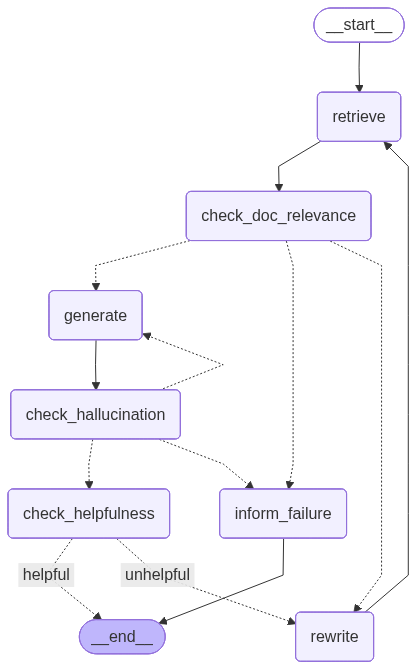

In [17]:
# 그래프 시각화 
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
# 그래프 실행 
query = "연봉 5천만원인 직장인의 소득세는 얼마인가요?"
initial_state = {'query': query, 'generation_count': 0, 'rewrite_count': 0} 
result = graph.invoke(initial_state)

In [23]:
result.get("answer")

'연봉 5천만원인 직장인의 소득세는 과세표준에 따라 계산됩니다. 5천만원 초과 8,800만원 이하 구간에는 624만원 + 초과 금액의 24%가 적용됩니다. 따라서, 연봉 5천만원의 경우 근로소득에 대해 기본세율로 소득세를 계산하게 됩니다.'